In [2]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
import pandas as pd

dfs = {
    2019: pd.read_csv('final2019.csv'),
    2020: pd.read_csv('final2020.csv'),
    2021: pd.read_csv('final2021.csv'),
    2022: pd.read_csv('final2022.csv'),
    2023: pd.read_csv('final2023.csv'),
}

for year, df in dfs.items():
    print(f"--- Colonnes {year} ---")
    print(df.columns.tolist(), "\n")


/tmp/ipykernel_383756/483897370.py:4: DtypeWarning: Columns (7,8,20,22,24,26,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2019: pd.read_csv('final2019.csv'),
/tmp/ipykernel_383756/483897370.py:5: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2020: pd.read_csv('final2020.csv'),
/tmp/ipykernel_383756/483897370.py:6: DtypeWarning: Columns (7,8,18,20,22,28,30,32,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  2021: pd.read_csv('final2021.csv'),
/tmp/ipykernel_383756/483897370.py:7: DtypeWarning: Columns (7,8,20,22,24,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  2022: pd.read_csv('final2022.csv'),


--- Colonnes 2019 ---
['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment', 'Année_construction', 'Période_construction', 'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)', 'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', 'valeur_fonciere', 'adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune', 'nom_commune', 'code_departement', 'ancien_code_commune', 'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale', 'nature_culture_speciale', 'surface_terrain', 'longitude', '

/tmp/ipykernel_383756/483897370.py:8: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  2023: pd.read_csv('final2023.csv'),


In [4]:
import pandas as pd

# 1) Concaténation
df = pd.concat(dfs.values(), ignore_index=True)
print("Shape après concaténation :", df.shape)

# 2) Date → datetime + extraction de l'année
df['date_mutation'] = pd.to_datetime(df['date_mutation'], dayfirst=True, errors='coerce')
df['year'] = df['date_mutation'].dt.year

Shape après concaténation : (543908, 51)


/tmp/ipykernel_383756/2325805555.py:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date_mutation'] = pd.to_datetime(df['date_mutation'], dayfirst=True, errors='coerce')


In [14]:
# 1) Nettoyage de la variable DPE
df['dpe_clean'] = df['Etiquette_DPE'].str.upper().str.strip()

# 2) Indicatrice traitement
df['treat'] = df['dpe_clean'].isin(['F','G']).astype(int)

# 3) Indicatrice post‑loi (on prend l'année >= 2022)
df['post']  = (df['year'] >= 2022).astype(int)

# 4) Interaction DiD
df['did']   = df['treat'] * df['post']

# 5) Vérif rapide : effectifs de chaque combinason
print(df[['treat','post','did']].value_counts().sort_index())


treat  post  did
0      0     0      209193
       1     0      247182
1      0     0       41604
       1     1       45929
Name: count, dtype: int64


In [8]:
# 1) liste des contrôles
controls = [
    'Surface_habitable_logement',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'surface_terrain',
    'Année_construction'
]

# 2) construction de la liste complète des variables du modèle
vars_model = ['valeur_fonciere', 'treat', 'post', 'did', 'code_departement'] + controls

# 3) comptage des missing
missing = df[vars_model].isna().sum().rename('n_missing')
total   = df[vars_model].shape[0]
pct     = (missing / total * 100).round(2).rename('pct_missing')
print(pd.concat([missing, pct], axis=1))

# 4) création du jeu clean (drop NA)
df_mod = df.dropna(subset=vars_model)
print(f"\nObservations avant : {total:,}  –  après dropna : {len(df_mod):,}")


KeyError: "['post'] not in index"

In [16]:
import pandas as pd

# 1) Indicateur de missing + imputation pour l'année de construction
df['year_const_miss'] = df['Année_construction'].isna().astype(int)
median_year = df['Année_construction'].median()
df['Année_construction_imp'] = df['Année_construction'].fillna(median_year)

# 2) Nouvelle liste de contrôles (sans surface_terrain, avec l’imputation)
controls2 = [
    'Surface_habitable_logement',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'Année_construction_imp',
    'year_const_miss'
]

vars_model2 = ['valeur_fonciere', 'treat', 'post', 'did', 'code_departement'] + controls2

# 3) Nouveau diagnostic des missing
missing2 = df[vars_model2].isna().sum().rename('n_missing')
pct2     = (missing2 / df.shape[0] * 100).round(2).rename('pct_missing')
print(pd.concat([missing2, pct2], axis=1))

# 4) Jeu « clean » après dropna
df_mod2 = df.dropna(subset=vars_model2)
print(f"\nObservations avant : {df.shape[0]:,}  –  après dropna : {len(df_mod2):,}")


                            n_missing  pct_missing
valeur_fonciere                    29         0.01
treat                               0         0.00
post                                0         0.00
did                                 0         0.00
code_departement                    0         0.00
Surface_habitable_logement          0         0.00
surface_reelle_bati                 0         0.00
nombre_pieces_principales           0         0.00
Année_construction_imp              0         0.00
year_const_miss                     0         0.00

Observations avant : 543,908  –  après dropna : 543,879


In [18]:
# Avant d'ajuster le modèle, uniformisons les codes départements en str
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# Puis on relance l’OLS clusterisé :
import statsmodels.formula.api as smf

formula = (
    'valeur_fonciere ~ treat + post + treat:post'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)

model = smf.ols(formula, data=df_mod2)
res = model.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(res.summary())


/tmp/ipykernel_320048/1587717805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)


                            OLS Regression Results                            
Dep. Variable:        valeur_fonciere   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.395
Date:                Fri, 18 Apr 2025   Prob (F-statistic):            0.00203
Time:                        17:32:31   Log-Likelihood:            -9.6600e+06
No. Observations:              543879   AIC:                         1.932e+07
Df Residuals:                  543870   BIC:                         1.932e+07
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [19]:
df_mod2 = df_mod2.copy()
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)


In [20]:
import numpy as np
df_mod2['ln_val'] = np.log(df_mod2['valeur_fonciere'] + 1)

formula_log = (
    'ln_val ~ treat + post + treat:post'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)
model_log = smf.ols(formula_log, data=df_mod2.copy())
res_log   = model_log.fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)
print(res_log.summary())


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     106.6
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.24e-40
Time:                        17:34:09   Log-Likelihood:            -6.5394e+05
No. Observations:              543879   AIC:                         1.308e+06
Df Residuals:                  543870   BIC:                         1.308e+06
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
formula_fe = (
    'ln_val ~ treat:post'
    ' + C(code_departement)'
    ' + C(year)'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)
res_fe = smf.ols(formula_fe, data=df_mod2.copy()).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)
print(res_fe.summary()) 


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 93, but rank is 10
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.448e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.46e-171
Time:                        17:35:42   Log-Likelihood:            -5.5419e+05
No. Observations:              543879   AIC:                         1.109e+06
Df Residuals:                  543785   BIC:                         1.110e+06
Df Model:                          93                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [48]:
formula_fe = (
    'ln_val ~ treat:post'
    ' + C(code_departement)'
    ' + C(year)'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)
res_fe = smf.ols(formula_fe, data=df_mod2.copy()).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)
print(res_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 93, but rank is 10
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.448e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.46e-171
Time:                        18:14:45   Log-Likelihood:            -5.5419e+05
No. Observations:              543879   AIC:                         1.109e+06
Df Residuals:                  543785   BIC:                         1.110e+06
Df Model:                          93                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [54]:
import statsmodels.formula.api as smf

# On part de df_mod2 qui contient déjà :
#  - ln_val = np.log(valeur_fonciere + 1) ou sans +1 si pas de zéros
#  - treat, post, year, code_departement
#  - contrôle: Surface_habitable_logement, surface_reelle_bati,
#              nombre_pieces_principales, Année_construction_imp, year_const_miss

formula = (
    'ln_val ~ treat + post + treat:post'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
    ' + C(code_departement)'   # FE par département
                   # FE par année
)

# estimation OLS avec clustering par département
res = smf.ols(formula, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(res.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 91, but rank is 8
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.726e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          9.20e-172
Time:                        19:13:26   Log-Likelihood:            -5.5448e+05
No. Observations:              543879   AIC:                         1.109e+06
Df Residuals:                  543787   BIC:                         1.110e+06
Df Model:                          91                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [56]:
import numpy as np
import statsmodels.formula.api as smf

# 1) On s’assure que code_departement est bien traité en chaîne
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)

# 2) On construit la variable dépendante log‑prix
df_mod2['ln_val'] = np.log(df_mod2['valeur_fonciere'])

# 3) Spécification à effets fixes
formula_fe = (
    'ln_val ~ treat:post'               # interaction DiD
    ' + C(code_departement)'            # fixe département μᵢ
    ' + C(year)'                        # fixe année λₜ
    ' + Surface_habitable_logement'     # contrôles
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)

# 4) Estimation clusterisée par département
res_fe = smf.ols(formula_fe, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

# 5) Résumé des résultats
print(res_fe.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 93, but rank is 10
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.450e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.38e-171
Time:                        19:17:32   Log-Likelihood:            -5.5594e+05
No. Observations:              543879   AIC:                         1.112e+06
Df Residuals:                  543785   BIC:                         1.113e+06
Df Model:                          93                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [53]:
import statsmodels.formula.api as smf

# On part de df_mod2 qui contient déjà :
#   ln_val, treat, post, code_departement, year_const_miss, Année_construction_imp, etc.

formula_no_fe = (
    'ln_val ~ treat + post + treat:post'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)

res_no_fe = smf.ols(formula_no_fe, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)

print(res_no_fe.summary())


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     106.6
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.24e-40
Time:                        19:12:13   Log-Likelihood:            -6.5394e+05
No. Observations:              543879   AIC:                         1.308e+06
Df Residuals:                  543870   BIC:                         1.308e+06
Df Model:                           8                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [34]:
# Renommer les dummies
rename_map = {
    'event_-3': 'event_m3',
    'event_-2': 'event_m2'
    # 'event_-1' n'existe pas, on a sauté t = -1
}
df_mod2 = df_mod2.rename(columns=rename_map)

# Reconstruire la liste des variables leads/lags
leads_lags = ['event_m3','event_m2','event_0','event_1','event_2','event_3']

# Puis la formule
formula_es = (
    'ln_val ~ ' + ' + '.join(leads_lags)
    + ' + C(code_departement) + C(year)'
    + ' + Surface_habitable_logement'
    + ' + surface_reelle_bati'
    + ' + nombre_pieces_principales'
    + ' + Année_construction_imp'
    + ' + year_const_miss'
)

res_es = smf.ols(formula_es, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement'].astype(str)}
)
print(res_es.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 98, but rank is 13
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 1.346e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.50e-173
Time:                        17:55:12   Log-Likelihood:            -5.5403e+05
No. Observations:              543879   AIC:                         1.108e+06
Df Residuals:                  543782   BIC:                         1.109e+06
Df Model:                          96                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
# Liste des periods dans votre jeu
unique_periods = sorted(df_mod2['period'].unique())
print("Periods observés :", unique_periods)


Periods observés : [np.int32(-3), np.int32(-2), np.int32(-1), np.int32(0), np.int32(1)]


In [36]:
# Supposons que df_mod2['period'] et df_mod2['treat'] existent déjà
periods = sorted(df_mod2['period'].unique())
leads_lags = []
for t in periods:
    if t == -1:
        continue
    # Nommer proprement, sans tirets :
    name = f"event_m{abs(t)}" if t < 0 else f"event_{t}"
    df_mod2[name] = ((df_mod2['period'] == t) & (df_mod2['treat'] == 1)).astype(int)
    leads_lags.append(name)


In [38]:
import statsmodels.formula.api as smf
import re

formula_es = (
    'ln_val ~ ' + ' + '.join(leads_lags)
    + ' + C(code_departement) + C(year)'
    + ' + Surface_habitable_logement'
    + ' + surface_reelle_bati'
    + ' + nombre_pieces_principales'
    + ' + Année_construction_imp'
    + ' + year_const_miss'
)
res_es = smf.ols(formula_es, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement'].astype(str)}
)

# Extraction
es_params = res_es.params.filter(like='event_')
es_se     = res_es.bse.filter(like='event_')
df_es = pd.DataFrame({
    't': [int(re.sub(r'event_m?','', name)) for name in es_params.index],
    'coef': es_params.values,
    'ci_low': es_params.values - 1.96 * es_se.values,
    'ci_high': es_params.values + 1.96 * es_se.values
}).sort_values('t')

print(df_es)


   t      coef    ci_low   ci_high
2  0 -0.107613 -0.173905 -0.041321
3  1 -0.130491 -0.163030 -0.097952
1  2 -0.101974 -0.134324 -0.069624
0  3 -0.064207 -0.112562 -0.015852


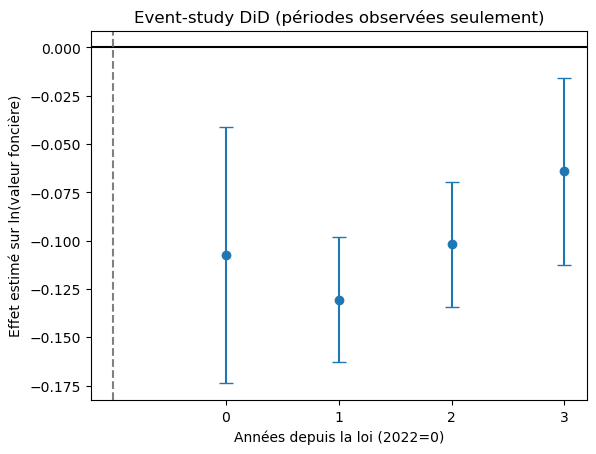

In [39]:
import matplotlib.pyplot as plt

plt.errorbar(df_es['t'], df_es['coef'],
             yerr=[df_es['coef'] - df_es['ci_low'], df_es['ci_high'] - df_es['coef']],
             fmt='o', capsize=5)
plt.axhline(0, color='k')
plt.axvline(-1, color='grey', linestyle='--')
plt.xticks(df_es['t'])
plt.xlabel("Années depuis la loi (2022=0)")
plt.ylabel("Effet estimé sur ln(valeur foncière)")
plt.title("Event‑study DiD (périodes observées seulement)")
plt.show()


In [40]:
# on a déjà :
# es_params = res_es.params.filter(like='event_')
# es_se     = res_es.bse.filter(like='event_')

rows = []
for name, coef, se in zip(es_params.index, es_params.values, es_se.values):
    if name.startswith('event_m'):
        # event_m3 → t = -3
        t = -int(name.split('event_m')[1])
    else:
        # event_0 → t = 0 ; event_1 → t = 1
        t = int(name.split('event_')[1])
    ci_low  = coef - 1.96 * se
    ci_high = coef + 1.96 * se
    rows.append({'t': t, 'coef': coef, 'ci_low': ci_low, 'ci_high': ci_high})

df_es = pd.DataFrame(rows).sort_values('t')
print(df_es)


   t      coef    ci_low   ci_high
0 -3 -0.064207 -0.112562 -0.015852
1 -2 -0.101974 -0.134324 -0.069624
2  0 -0.107613 -0.173905 -0.041321
3  1 -0.130491 -0.163030 -0.097952


In [41]:
# 1) Créer la variable de trend
df_mod2['trend'] = df_mod2['year'] - df_mod2['year'].min()

# 2) Régression DiD augmentée
formula_trend = (
    'ln_val ~ treat*trend + post + treat:post'
    ' + C(code_departement) + C(year)'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)
res_trend = smf.ols(formula_trend, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement'].astype(str)}
)
print(res_trend.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 97, but rank is 12
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 1.110e+05
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          4.32e-169
Time:                        18:02:22   Log-Likelihood:            -5.5391e+05
No. Observations:              543879   AIC:                         1.108e+06
Df Residuals:                  543783   BIC:                         1.109e+06
Df Model:                          95                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [42]:
df_es_short = df_mod2[df_mod2['period'].between(2022-1, 2022+2)]
# puis relancer l’event-study ou le DiD simple sur ce sous-échantillon


   t      coef    ci_low   ci_high
0  0 -0.102032 -0.165319 -0.038745
1  1 -0.126622 -0.156935 -0.096309


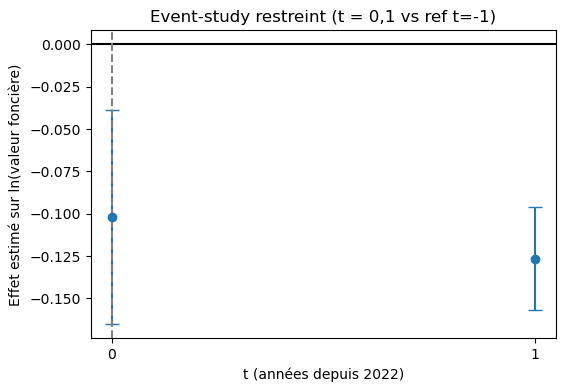

In [43]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1) Sous‑échantillon : period ∈ [‑1, +1]
df_win = df_mod2[df_mod2['period'].between(-1, 1)].copy()

# 2) Créer les dummies event pour t = -1, 0, +1
#    (on prendra t=-1 comme référence)
for t in [-1, 0, 1]:
    name = f"event_m1" if t==-1 else f"event_{t}"
    df_win[name] = ((df_win['period'] == t) & (df_win['treat'] == 1)).astype(int)

# 3) Préparer la liste des leads/lags et la formule
leads_lags = ['event_0', 'event_1']  # event_m1 est la référence, on ne l’inclut pas
formula_es_win = (
    'ln_val ~ ' + ' + '.join(leads_lags)
    + ' + C(code_departement) + C(year)'
    + ' + Surface_habitable_logement'
    + ' + surface_reelle_bati'
    + ' + nombre_pieces_principales'
    + ' + Année_construction_imp'
    + ' + year_const_miss'
)

# 4) Estimation clusterisée
res_es_win = smf.ols(formula_es_win, data=df_win).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_win['code_departement'].astype(str)}
)

# 5) Extraire et organiser
es_params = res_es_win.params.filter(like='event_')
es_se     = res_es_win.bse.filter(like='event_')
rows = []
for name, coef, se in zip(es_params.index, es_params.values, es_se.values):
    t = int(name.split('event_')[1])
    ci_low, ci_high = coef - 1.96*se, coef + 1.96*se
    rows.append({'t': t, 'coef': coef, 'ci_low': ci_low, 'ci_high': ci_high})
df_es_win = pd.DataFrame(rows).sort_values('t')
print(df_es_win)

# 6) Trace rapide
plt.figure(figsize=(6,4))
plt.errorbar(df_es_win['t'], df_es_win['coef'],
             yerr=[df_es_win['coef']-df_es_win['ci_low'], 
                   df_es_win['ci_high']-df_es_win['coef']],
             fmt='o', capsize=5)
plt.axhline(0, color='k')
plt.axvline(0, color='grey', linestyle='--')
plt.xticks(df_es_win['t'])
plt.xlabel("t (années depuis 2022)")
plt.ylabel("Effet estimé sur ln(valeur foncière)")
plt.title("Event‑study restreint (t = 0,1 vs ref t=-1)")
plt.show()


In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# 1) Sous‑échantillon avant la loi
df_pre = df_mod2[df_mod2['year'] < 2022].copy()

# 2) Choix des covariables pour le matching
covs = [
    'Surface_habitable_logement',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'Année_construction_imp',
    'year_const_miss'
]

# 3) Estimation du propensity score
X = df_pre[covs]
y = df_pre['treat']
ps_model = LogisticRegression(max_iter=1000).fit(X, y)
df_pre['pscore'] = ps_model.predict_proba(X)[:, 1]

# 4) Séparation traités / contrôles
treated = df_pre[df_pre['treat'] == 1]
control = df_pre[df_pre['treat'] == 0]

# 5) Matching 1‑à‑1 nearest‑neighbor sur le pscore
nn = NearestNeighbors(n_neighbors=1).fit(control[['pscore']])
distances, indices = nn.kneighbors(treated[['pscore']])
control_matches = control.iloc[indices.flatten()].copy()

# 6) Constituer l’échantillon apparié
matched = pd.concat([treated, control_matches], ignore_index=True)
print("Taille de l’échantillon apparié :", matched.shape)

# 7) Vérification sommaire du balance sur les covariables
balance = matched.groupby('treat')[covs].mean().T
print("\nMoyennes des covariables par groupe après matching :")
print(balance)


Taille de l’échantillon apparié : (83200, 68)

Moyennes des covariables par groupe après matching :
treat                                 0            1
Surface_habitable_logement    61.247349    60.849361
surface_reelle_bati           61.115361    60.733990
nombre_pieces_principales      2.945745     2.924447
Année_construction_imp      1910.046442  1921.571827
year_const_miss                0.000337     0.000409


In [45]:
import statsmodels.formula.api as smf

# 1) On redéfinit post (= year≥2022) et ln_val si nécessaire
matched['post'] = (matched['year'] >= 2022).astype(int)
matched['ln_val'] = np.log(matched['valeur_fonciere'] + 1)

# 2) Formule DiD avec covariables
formula_matched = (
    'ln_val ~ treat + post + treat:post'
    ' + Surface_habitable_logement'
    ' + surface_reelle_bati'
    ' + nombre_pieces_principales'
    ' + Année_construction_imp'
    ' + year_const_miss'
)

# 3) Estimation clusterisée
res_matched = smf.ols(formula_matched, data=matched).fit(
    cov_type='cluster',
    cov_kwds={'groups': matched['code_departement'].astype(str)}
)

# 4) Résumé
print(res_matched.summary())


                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     56.24
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           3.45e-27
Time:                        18:08:35   Log-Likelihood:                -99430.
No. Observations:               83200   AIC:                         1.989e+05
Df Residuals:                   83193   BIC:                         1.989e+05
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  warnings.warn('covariance of constraints does not have full '


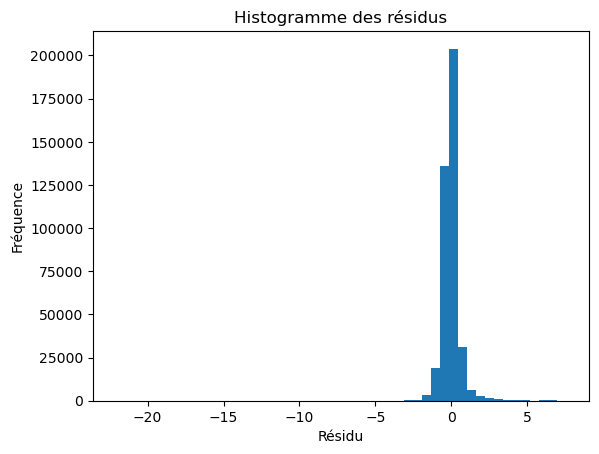

<Figure size 640x480 with 0 Axes>

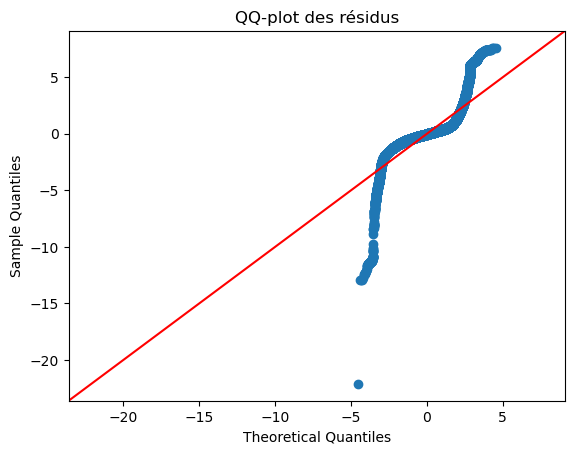

Breusch-Pagan p-value: 0.0000


In [46]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# 1) Récupérer les résidus
resid = res_es_win.resid

# 2) Histogramme
plt.figure()
plt.hist(resid, bins=50)
plt.title("Histogramme des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.show()

# 3) QQ‑plot
plt.figure()
sm.qqplot(resid, line='45')
plt.title("QQ‑plot des résidus")
plt.show()

# 4) Test de Breusch‑Pagan (hétéroscédasticité)
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, res_es_win.model.exog)
print(f"Breusch-Pagan p-value: {lm_pvalue:.4f}")


In [49]:
# Afficher la liste des colonnes de df
print(df.columns)


Index(['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment',
       'Année_construction', 'Période_construction',
       'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)',
       'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation',
       'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_natu

In [ ]:
# 1) Nettoyage de la variable DPE
df['dpe_clean'] = df['Etiquette_DPE'].str.upper().str.strip()


# 2) Indicatrice traitement
df['treat'] = df['dpe_clean'].isin(['F','G']).astype(int)


df['post_exact'] = (df['date_mutation'] >= '2021-08-24').astype(int)
df['did']   = df['treat'] * df['post_exact']


NameError: name 'df_mod2' is not defined

In [50]:
# 1) liste des contrôles
controls = [
    'Surface_habitable_logement',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'surface_terrain',
    'Type_bâtiment',
    'Année_construction'
]

# 2) construction de la liste complète des variables du modèle
vars_model = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls

# 3) comptage des missing
missing = df[vars_model].isna().sum().rename('n_missing')
total   = df[vars_model].shape[0]
pct     = (missing / total * 100).round(2).rename('pct_missing')
print(pd.concat([missing, pct], axis=1))

# 4) création du jeu clean (drop NA)
df_mod = df.dropna(subset=vars_model)
print(f"\nObservations avant : {total:,}  –  après dropna : {len(df_mod):,}")


                            n_missing  pct_missing
valeur_fonciere                    29         0.01
treat                               0         0.00
post_exact                          0         0.00
did                                 0         0.00
code_departement                    0         0.00
Surface_habitable_logement          0         0.00
surface_reelle_bati                 0         0.00
nombre_pieces_principales           0         0.00
surface_terrain                390143        71.73
Type_bâtiment                       0         0.00
Année_construction              99451        18.28

Observations avant : 543,908  –  après dropna : 126,294


In [52]:
import pandas as pd

# 1) Indicateur de missing + imputation pour l'année de construction
df['year_const_miss'] = df['Année_construction'].isna().astype(int)
median_year = df['Année_construction'].median()
df['Année_construction_imp'] = df['Année_construction'].fillna(median_year)

# 2) Nouvelle liste de contrôles (sans surface_terrain, avec l’imputation)
controls2 = [
    'Type_bâtiment',
    'surface_reelle_bati',
    'Année_construction_imp',
    'year_const_miss'
]

vars_model2 = ['valeur_fonciere', 'treat', 'post_exact', 'did', 'code_departement'] + controls2

# 3) Nouveau diagnostic des missing
missing2 = df[vars_model2].isna().sum().rename('n_missing')
pct2     = (missing2 / df.shape[0] * 100).round(2).rename('pct_missing')
print(pd.concat([missing2, pct2], axis=1))

# 4) Jeu « clean » après dropna
df_mod2 = df.dropna(subset=vars_model2)
print(f"\nObservations avant : {df.shape[0]:,}  –  après dropna : {len(df_mod2):,}")


                        n_missing  pct_missing
valeur_fonciere                29         0.01
treat                           0         0.00
post_exact                      0         0.00
did                             0         0.00
code_departement                0         0.00
Type_bâtiment                   0         0.00
surface_reelle_bati             0         0.00
Année_construction_imp          0         0.00
year_const_miss                 0         0.00

Observations avant : 543,908  –  après dropna : 543,879


In [53]:
df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)
df_mod2['ln_val'] = np.log(df_mod2['valeur_fonciere'])
formula_fe_date = (
    'ln_val ~ treat + treat:post_exact'
    ' + C(code_departement)'
    ' + C(year)'
    ' + surface_reelle_bati'
    ' + Type_bâtiment'
    ' + Année_construction_imp'
    ' + year_const_miss'
)
res_fe_date = smf.ols(formula_fe_date, data=df_mod2).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_mod2['code_departement']}
)
print(res_fe_date.summary())

/tmp/ipykernel_383756/3537756968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['code_departement'] = df_mod2['code_departement'].astype(str)
/tmp/ipykernel_383756/3537756968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['ln_val'] = np.log(df_mod2['valeur_fonciere'])
/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 94, but rank is 11
  warnings.warn('covariance of c

                            OLS Regression Results                            
Dep. Variable:                 ln_val   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     1412.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           1.93e-89
Time:                        11:04:10   Log-Likelihood:            -5.5586e+05
No. Observations:              543879   AIC:                         1.112e+06
Df Residuals:                  543784   BIC:                         1.113e+06
Df Model:                          94                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [43]:
# Modifier la variable 'treated' pour que le groupe traité soit E-F
df_mod2.loc[:, 'treated'] = df_mod2['Etiquette_DPE'].apply(lambda x: 1 if x in ['E', 'F', 'G'] else (0 if x in ['A', 'B', 'C'] else -1))

# Ajouter la variable 'treated' dans la régression
formula_fe = (
    'ln_val ~ treated + treated:post_exact + type_batiment + C(code_departement) + C(year)  +'
    'surface_reelle_bati + Année_construction_imp + year_const_miss'
)
res_fe = smf.ols(formula_fe, data=df_mod2.copy()).fit(cov_type='cluster', cov_kwds={'groups': df_mod2['code_departement']})

# Afficher les résultats de la régression
print(res_fe.summary())


PatsyError: Error evaluating factor: NameError: name 'type_batiment' is not defined
    ln_val ~ treated + treated:post_exact + type_batiment + C(code_departement) + C(year)  +surface_reelle_bati + Année_construction_imp + year_const_miss
                                            ^^^^^^^^^^^^^

In [20]:
df_mod2['treated'] = df_mod2['Etiquette_DPE'].apply(lambda x: 1 if x in ['E', 'F', 'G'] else (0 if x in ['A', 'B', 'C'] else -1))



/tmp/ipykernel_383756/2620565511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod2['treated'] = df_mod2['Etiquette_DPE'].apply(lambda x: 1 if x in ['E', 'F', 'G'] else (0 if x in ['A', 'B', 'C'] else -1))


In [21]:
print(df_mod2[df_mod2['treated'] == 0]['Etiquette_DPE'].unique())


['B' 'C' 'A']


In [26]:
df['code_departement'] = df['code_departement'].astype(str)


In [25]:
print(X.dtypes)


const                         float64
valeur_fonciere               float64
treat                           int64
post_exact                      int64
did                             int64
code_departement               object
Surface_habitable_logement    float64
surface_reelle_bati           float64
nombre_pieces_principales     float64
Année_construction_imp        float64
year_const_miss                 int64
dtype: object


In [55]:
# S'assurer que toutes les variables sont de type numérique
X = df[[ 'surface_reelle_bati',  
        'Année_construction_imp', 'year_const_miss', 'treat', 'post_exact', 'did']]

# Convertir toutes les colonnes en numériques, en remplaçant les erreurs par NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Supprimer les lignes contenant des valeurs manquantes
X = X.dropna()

# Calculer le VIF pour chaque variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher les résultats
print(vif)


                 Variable       VIF
0     surface_reelle_bati  4.703260
1  Année_construction_imp  7.118903
2         year_const_miss  1.398613
3                   treat  3.299400
4              post_exact  3.772322
5                     did  3.309961


In [36]:
# Exclure les colonnes non numériques
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calculer la matrice de corrélation
correlation_matrix = df_numeric.corr()
print(correlation_matrix)


                            Année_construction  Surface_habitable_logement  \
Année_construction                    1.000000                    0.005610   
Surface_habitable_logement            0.005610                    1.000000   
numero_disposition                    0.001136                    0.043726   
valeur_fonciere                       0.006127                    0.003232   
adresse_numero                        0.019945                    0.006417   
code_postal                          -0.056645                   -0.040636   
ancien_code_commune                   0.042084                    0.641335   
numero_volume                              NaN                         NaN   
lot1_surface_carrez                  -0.014503                    0.218108   
lot2_surface_carrez                  -0.014043                    0.386604   
lot3_surface_carrez                  -0.008941                    0.828326   
lot4_numero                          -0.053274                  